In [1]:
#https://github.com/dacatay/time-series-analysis/blob/master/Stock_Market_Prediction.ipynb

In [2]:
%run 'data_preparation.ipynb'

In [3]:
# prepare the data set
df = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))
#df.reset_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2014-01-01 to 2016-12-31
Data columns (total 1 columns):
BOOKING_HAL_ID    1096 non-null int64
dtypes: int64(1)
memory usage: 17.1 KB


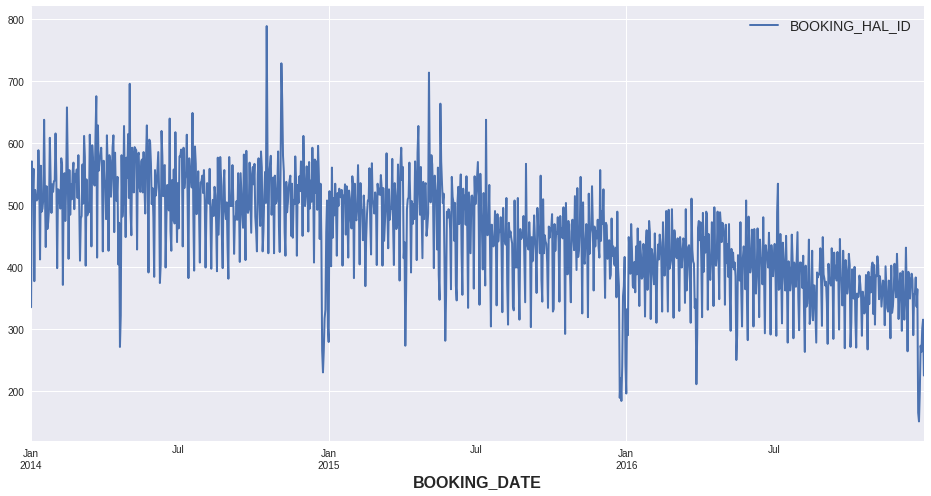

In [5]:
df.plot()

In [6]:
df['returns'] = np.log(df / df.shift(1))

In [7]:
df.head()

,BOOKING_HAL_ID,returns
BOOKING_DATE,,
2014-01-01,335,NaN
2014-01-02,570,0.531506
2014-01-03,510,-0.111226
2014-01-04,558,0.089948
2014-01-05,377,-0.392114


In [8]:
def create_data_set(df, lags=1):
    """
    For given df transform into lagged dataset
    """
    cols = []
    for lag in range(1, lags+1):
        col = 'lag_%d' % lag
        df[col] = df['returns'].shift(lag)
        cols.append(col)
        
    return df, cols

In [9]:
# define lags
lags=5

# create new data
df, cols = create_data_set(df, lags=lags)

In [10]:
df.head(10)

,BOOKING_HAL_ID,returns,lag_1,lag_2,lag_3,lag_4,lag_5
BOOKING_DATE,,,,,,,
2014-01-01,335,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,570,0.531506,NaN,NaN,NaN,NaN,NaN
2014-01-03,510,-0.111226,0.531506,NaN,NaN,NaN,NaN
2014-01-04,558,0.089948,-0.111226,0.531506,NaN,NaN,NaN
2014-01-05,377,-0.392114,0.089948,-0.111226,0.531506,NaN,NaN
2014-01-06,524,0.329246,-0.392114,0.089948,-0.111226,0.531506,NaN
2014-01-07,509,-0.029044,0.329246,-0.392114,0.089948,-0.111226,0.531506
2014-01-08,507,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-0.111226
2014-01-09,510,0.005900,-0.003937,-0.029044,0.329246,-0.392114,0.089948


In [11]:
df.dropna(inplace=True)

In [12]:
df.head()

,BOOKING_HAL_ID,returns,lag_1,lag_2,lag_3,lag_4,lag_5
BOOKING_DATE,,,,,,,
2014-01-07,509,-0.029044,0.329246,-0.392114,0.089948,-0.111226,0.531506
2014-01-08,507,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-0.111226
2014-01-09,510,0.005900,-0.003937,-0.029044,0.329246,-0.392114,0.089948
2014-01-10,588,0.142316,0.005900,-0.003937,-0.029044,0.329246,-0.392114
2014-01-11,539,-0.087011,0.142316,0.005900,-0.003937,-0.029044,0.329246


# OLS Regression

In [13]:
reg = np.linalg.lstsq(df[cols].values, np.sign(df['returns'].values))[0]

/home/jawahar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [14]:
reg

array([-2.62083347, -1.79335118, -1.02359061, -0.13898621, -1.21537804])

In [15]:
pred = np.sign(np.dot(df[cols].values, reg))

In [16]:
pred

array([-1.,  1., -1., ...,  1., -1., -1.])

In [17]:
np.sign(df['returns'].values)

array([-1., -1.,  1., ...,  1.,  1., -1.])

In [18]:
df['ols_pred'] = pred

In [19]:
c = np.sign(df['returns'] * df['ols_pred'])

In [20]:
c.value_counts()

 1.0    787
-1.0    297
 0.0      6
dtype: int64

In [21]:
c.value_counts()[1] / (c.value_counts().sum())

0.7220183486238532

In [22]:
df['ols_returns'] = df['returns'] * df['ols_pred']

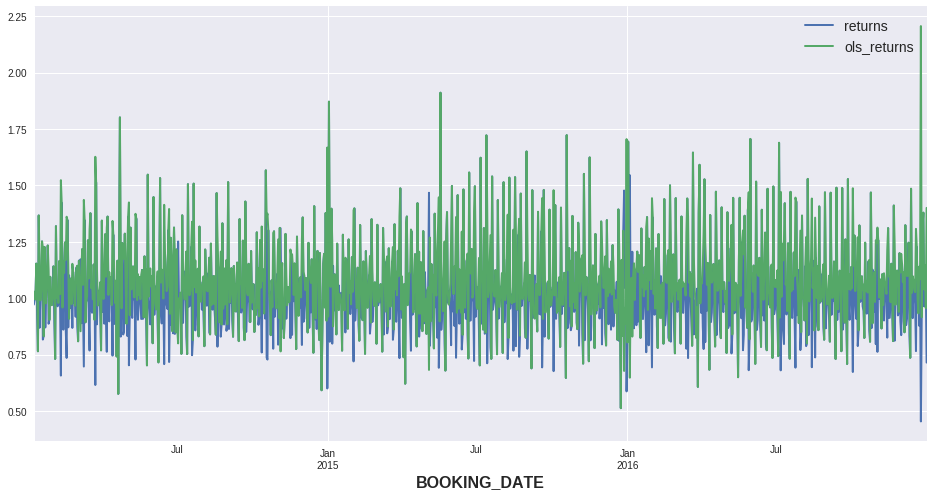

In [23]:
df[['returns', 'ols_returns']].apply(np.exp).plot()

# Logistic Regression

In [24]:
from sklearn import linear_model

In [25]:
lm = linear_model.LogisticRegression(C = 1e3)

In [26]:
lm.fit(df[cols], np.sign(df['returns']))

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [27]:
df['log_pred'] = lm.predict(df[cols])

In [28]:
df.head()

,BOOKING_HAL_ID,returns,lag_1,lag_2,lag_3,lag_4,lag_5,ols_pred,ols_returns,log_pred
BOOKING_DATE,,,,,,,,,,
2014-01-07,509,-0.029044,0.329246,-0.392114,0.089948,-0.111226,0.531506,-1.0,0.029044,-1.0
2014-01-08,507,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-0.111226,1.0,-0.003937,-1.0
2014-01-09,510,0.005900,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-1.0,-0.005900,-1.0
2014-01-10,588,0.142316,0.005900,-0.003937,-0.029044,0.329246,-0.392114,1.0,0.142316,1.0
2014-01-11,539,-0.087011,0.142316,0.005900,-0.003937,-0.029044,0.329246,-1.0,0.087011,-1.0


In [29]:
df['log_returns'] = df['returns'] * df['log_pred']

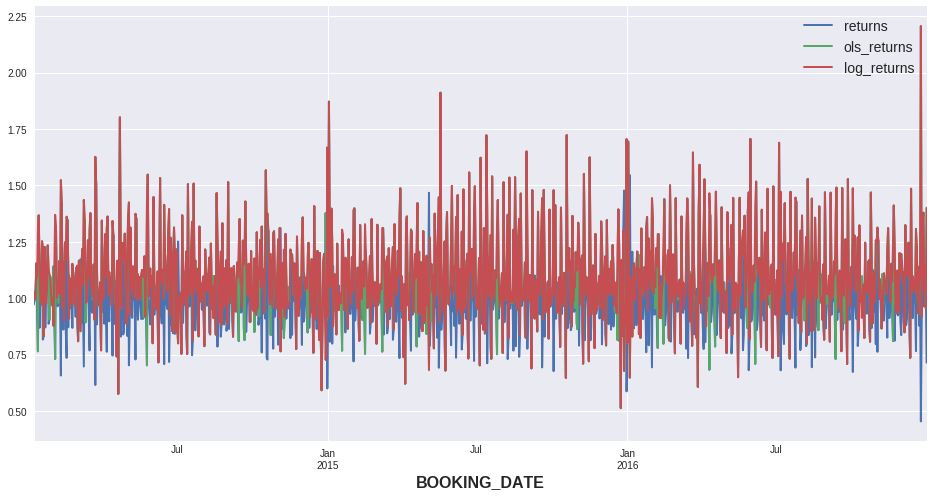

In [30]:
df[['returns', 'ols_returns', 'log_returns']].apply(np.exp).plot();

# Deep Neural Network

In [31]:
import tensorflow as tf

/home/jawahar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [32]:
from tensorflow import set_random_seed

In [33]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [34]:
mean = df['returns'].mean()

In [35]:
std = df['returns'].std()

In [36]:
print(mean, std)

-0.0007755883322170843 0.19676916880789588


In [37]:
fc = tf.contrib.layers.real_valued_column('returns', dimension=lags)

In [38]:
fcb = [tf.contrib.layers.bucketized_column(fc,
                    boundaries=[-0.0005, 0.0001, 0.0005])]

In [39]:
# [5, 8, 12, 8] overtraining

model = tf.contrib.learn.DNNClassifier(hidden_units=[20, 40],
                                       feature_columns=fcb)

In [40]:
def get_data():
    fc = {'returns': tf.constant(df[cols].values)}
    la = tf.constant((df['returns'] > 0).astype(int).values,
                     shape=[len(df), 1])
    return fc, la

In [41]:
np.random.seed(2)
set_random_seed(2)
model.fit(input_fn=get_data, steps=100)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7fd0abe17f98>, 'hidden_units': [20, 40], 'feature_columns': (_BucketizedColumn(source_column=_RealValuedColumn(column_name='returns', dimension=5, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(-0.0005, 0.0001, 0.0005)),), 'optimizer': None, 'activation_fn': <function relu at 0x7fd0b386c840>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [42]:
model.evaluate(input_fn=get_data, steps=1)

{'accuracy': 0.69908255,
 'accuracy/baseline_label_mean': 0.4440367,
 'accuracy/threshold_0.500000_mean': 0.69908255,
 'auc': 0.75748545,
 'auc_precision_recall': 0.73567593,
 'global_step': 100,
 'labels/actual_label_mean': 0.4440367,
 'labels/prediction_mean': 0.44076717,
 'loss': 0.5697975,
 'precision/positive_threshold_0.500000_mean': 0.7178771,
 'recall/positive_threshold_0.500000_mean': 0.53099173}

In [43]:
df['dnn_pred'] = list(model.predict(input_fn=get_data))
df['dnn_pred'] = np.where(df['dnn_pred'] > 0, 1.0, -1.0)

In [44]:
df['dnn_returns'] = df['returns'] * df['dnn_pred']

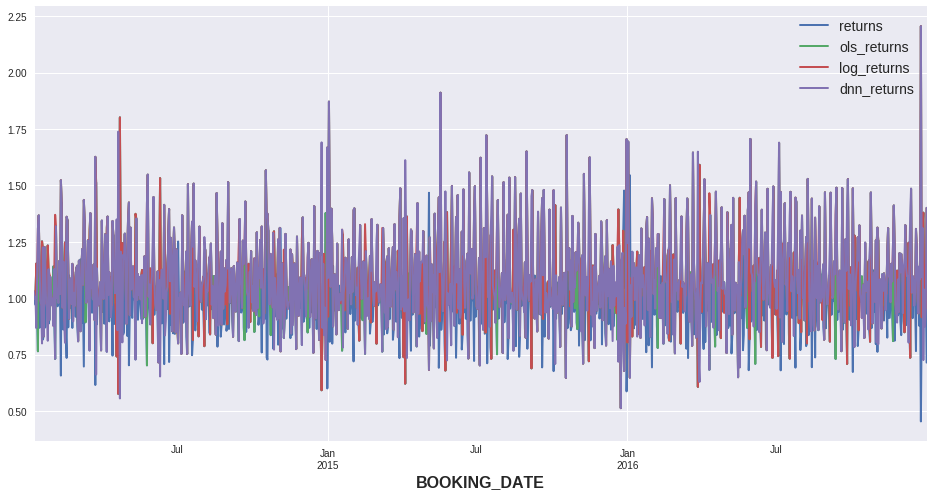

In [45]:
df[['returns', 'ols_returns', 'log_returns', 'dnn_returns']].apply(np.exp).plot()
plt.show()

In [46]:
per_day_tf_df = pd.DataFrame(df)

In [47]:
per_day_tf_df.reset_index(inplace=True)
per_day_tf_df.head()

,BOOKING_DATE,BOOKING_HAL_ID,returns,lag_1,lag_2,lag_3,lag_4,lag_5,ols_pred,ols_returns,log_pred,log_returns,dnn_pred,dnn_returns
0,2014-01-07,509,-0.029044,0.329246,-0.392114,0.089948,-0.111226,0.531506,-1.0,0.029044,-1.0,0.029044,-1.0,0.029044
1,2014-01-08,507,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-0.111226,1.0,-0.003937,-1.0,0.003937,1.0,-0.003937
2,2014-01-09,510,0.005900,-0.003937,-0.029044,0.329246,-0.392114,0.089948,-1.0,-0.005900,-1.0,-0.005900,1.0,0.005900
3,2014-01-10,588,0.142316,0.005900,-0.003937,-0.029044,0.329246,-0.392114,1.0,0.142316,1.0,0.142316,-1.0,-0.142316
4,2014-01-11,539,-0.087011,0.142316,0.005900,-0.003937,-0.029044,0.329246,-1.0,0.087011,-1.0,0.087011,-1.0,0.087011


In [49]:
trace0 = go.Scatter(
    x = per_day_tf_df.BOOKING_DATE,
    y = per_day_tf_df.returns,
    mode = 'lines+markers',
    name = 'laged returns'
)
trace1 = go.Scatter(
    x = per_day_tf_df.BOOKING_DATE,
    y = per_day_tf_df.ols_returns,
    mode = 'lines+markers',
    name = 'ols_returns'
)
trace2 = go.Scatter(
    x = per_day_tf_df.BOOKING_DATE,
    y = per_day_tf_df.log_returns,
    mode = 'lines',
    name = 'log_returns'
)
trace3 = go.Scatter(
    x = per_day_tf_df.BOOKING_DATE,
    y = per_day_tf_df.dnn_returns,
    mode = 'lines',
    name = 'dnn_returns'
)
fig = go.Figure(data=[trace0, trace1, trace2, trace3])
py.iplot(fig, filename="TensorFlow observations")

# Observations